# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

在本笔记本中，我们将训练一个多层感知器模型，以使用 PyTorch 对 MNIST 数字进行分类。

In [55]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1+cpu  Device: cpu


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation(验证)*, instead of for testing the final model.

In [56]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [57]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

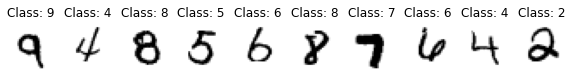

In [58]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #全连接层
        # weight: [28*28, 50]   bias: [50, ]
        self.fc1 = nn.Linear(28*28, 100)
        #在训练过程的前向传播中，让每个神经元以一定概率p处于不激活的状态。以达到减少过拟合的效果。
        self.fc1_drop = nn.Dropout(0.2)
        #全连接层
        self.fc2 = nn.Linear(100, 80)
        #在训练过程的前向传播中，让每个神经元以一定概率p处于不激活的状态。以达到减少过拟合的效果。
        self.fc2_drop = nn.Dropout(0.2)
        #全连接层
        self.fc3 = nn.Linear(80, 10)
        #self.relu1 = nn.ReLU() 

    def forward(self, x):
        #传入数字-1，自动对维度进行变换
        x = x.view(-1, 28*28)   # [32, 28*28]
        #relu激活函数对self.fc1(x)激活
        x = F.relu(self.fc1(x))
        #drop
        x = self.fc1_drop(x)
        #relu激活函数对self.fc2(x)激活
        x = F.relu(self.fc2(x))
        #drop
        x = self.fc2_drop(x)   # [32, 10]
        #self.fc3()全连接后，softmax激活
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
#随机梯度下降（优化器更新参数）
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#交叉熵损失函数
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [60]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        #梯度初始化为零，把loss关于weight的导数变成0
        optimizer.zero_grad() 
        
        # Pass data through the network
        #前向传播
        output = model(data)

        # Calculate loss
        #用交叉熵损失函数计算loss
        loss = criterion(output, target)

        # Backpropagate
        #反向传播
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [61]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [62]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294943
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.083004
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.261702
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.903394
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.697362
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.454854
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.442664
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.424397
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.480050
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.874457

Validation set: Average loss: 0.3487, Accuracy: 9000/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.633649
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.564961
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.272523
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.459976
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.229667
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.535762
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.212132
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.528343
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.25

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

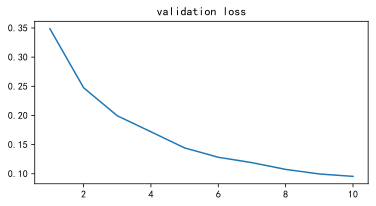

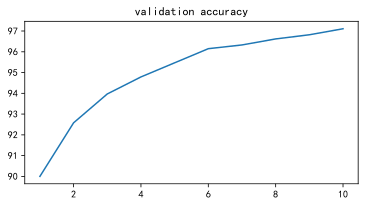

In [75]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(6,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.

## MLP_MIXER

In [64]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.nn import Conv2d
#网络结构可视化
from einops.layers.torch import Rearrange, Reduce
#数据可视化
from tensorboardX import SummaryWriter

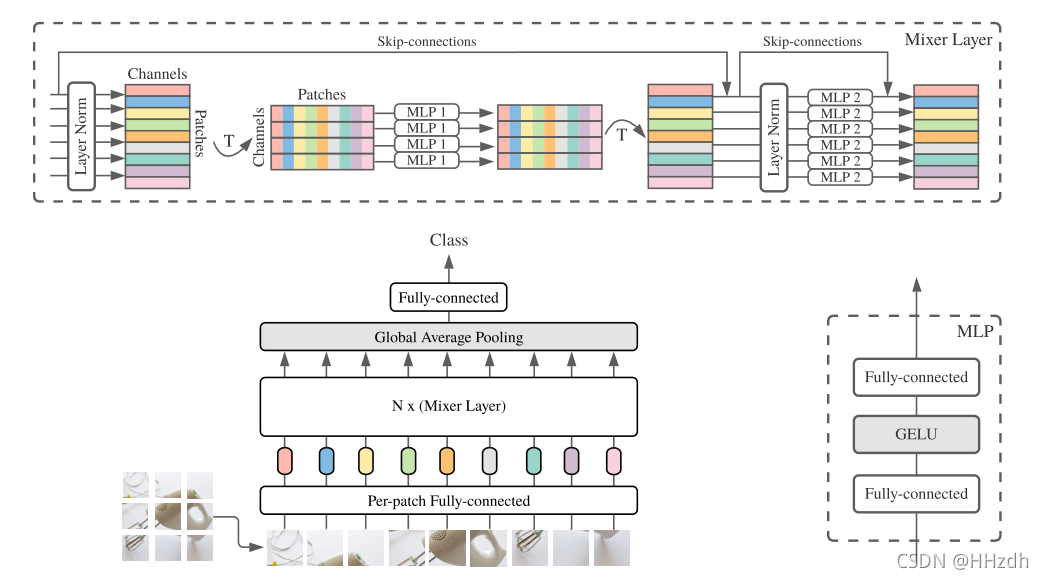

### MLP
Fully-connected->GELU->Fully-connected

In [65]:
# 因为有两个mixing,进出的维度都不变，只是中间全连接层的神经元数量不同
# 定义多层感知机
class FeedForward(nn.Module):
    def __init__(self,dim,hidden_dim,dropout=0.):
        super().__init__()
        self.net=nn.Sequential(
            #由此可以看出 FeedForward 的输入和输出维度是一致的
            nn.Linear(dim,hidden_dim),
            #激活函数
            nn.GELU(),
            #防止过拟合
            nn.Dropout(dropout),
            #重复上述过程
            nn.Linear(hidden_dim,dim),
            nn.Dropout(dropout)
        )
    def forward(self,x):
        x=self.net(x)
        return x

### Mixer Block

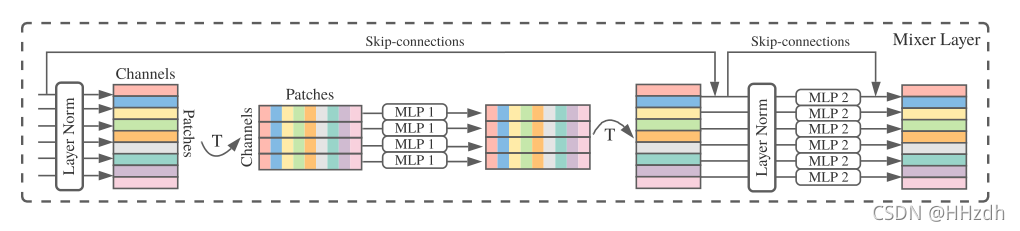

从Layer Norm层出来的为Patches*Channel(即为table)，每个patch即上述对同一位置的所有通道进行展开，

通过T转为Channel*Patches，token-mixing MLPs（MLP1）对table的列进行映射；

channel-mixing MLPs（MLP2）对table的行进行映射，对同一空间位置在不同通道上的信息进行映射；

In [66]:
class MixerBlock(nn.Module):
    def __init__(self,dim,num_patch,token_dim,channel_dim,dropout=0.):
        super().__init__()
        #MLP1：token_mixer对列进行映射
        self.token_mixer=nn.Sequential(
            nn.LayerNorm(dim),
            #进行转置，第一维不变，二维<->三维
            Rearrange('b n d -> b d n'),
            #num_patch=channels,且token_dim为内部节点数，输出输入相同
            FeedForward(num_patch,token_dim,dropout),
            #转置回来
            Rearrange('b d n -> b n d')
 
         )
        #MLP2：channel_mixer对行进行映射
        self.channel_mixer=nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim,channel_dim,dropout)
        )
    def forward(self,x):
        #跳跃连接
        x = x+self.token_mixer(x)
        x = x+self.channel_mixer(x)
        return x

### 搭建MLP_MIXER

In [67]:
class MLPMixer(nn.Module):
    def __init__(self,in_channels,dim,num_classes,patch_size,image_size,depth,token_dim,channel_dim,dropout=0.):
        super().__init__()
        #不能划分为一个个patch报错
        assert image_size%patch_size==0
        self.num_patches=(image_size//patch_size)**2   # （224/16）**2=196
        # embedding 操作，看见没用卷积来分成一小块一小块的
        # 通过embedding可以将这张3*224*224的图片转换为Channel*Patches=512*196，再通过Rearrange转为196*512
        self.to_embedding=nn.Sequential(
            #kernel_size=patch_size,stride=patch_size，切分
            Conv2d(in_channels=in_channels,out_channels=dim,kernel_size=patch_size,stride=patch_size),
            Rearrange('b c h w -> b (h w) c')
        )
 
        # 以下为token-mixing MLPs（MLP1）和channel-mixing MLPs（MLP2）各一层
        #N*MIX_block中的N为depth
        self.mixer_blocks=nn.ModuleList([])
        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim,self.num_patches,token_dim,channel_dim,dropout))
 
        #normal
        self.layer_normal=nn.LayerNorm(dim)
 
        #全连接层，输出分类
        self.mlp_head=nn.Sequential(
            nn.Linear(dim,num_classes)
        )
    def forward(self,x):
        x = self.to_embedding(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)
        x = self.layer_normal(x)
        #global average pooling 
        x = x.mean(dim=1)
        x = self.mlp_head(x)
        return x

### 网络结构

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MLPMIXER_model = MLPMixer(in_channels=1, dim=256, num_classes=10, patch_size=7, image_size=28, depth=1, token_dim=128,
                 channel_dim=1024).to(device)
summary(MLPMIXER_model,(1,28,28))

#随机梯度下降（优化器更新参数）
optimizer = torch.optim.SGD(MLPMIXER_model.parameters(), lr=0.01, momentum=0.5)
#交叉熵损失函数
criterion = nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 256, 4, 4]          12,800
         Rearrange-2              [-1, 16, 256]               0
         LayerNorm-3              [-1, 16, 256]             512
         Rearrange-4              [-1, 256, 16]               0
            Linear-5             [-1, 256, 128]           2,176
              GELU-6             [-1, 256, 128]               0
           Dropout-7             [-1, 256, 128]               0
            Linear-8              [-1, 256, 16]           2,064
           Dropout-9              [-1, 256, 16]               0
      FeedForward-10              [-1, 256, 16]               0
        Rearrange-11              [-1, 16, 256]               0
        LayerNorm-12              [-1, 16, 256]             512
           Linear-13             [-1, 16, 1024]         263,168
             GELU-14             [-1, 1

### 训练

In [69]:
def train(epoch, log_interval=200):
    # Set model to training mode
    MLPMIXER_model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        #梯度初始化为零，把loss关于weight的导数变成0
        optimizer.zero_grad() 
        
        # Pass data through the network
        #前向传播
        output = MLPMIXER_model(data)

        # Calculate loss
        #用交叉熵损失函数计算loss
        loss = criterion(output, target)

        # Backpropagate
        #反向传播
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [70]:
def validate(loss_vector, accuracy_vector):
    MLPMIXER_model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = MLPMIXER_model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [71]:
%%time
epochs = 10

MLPMixerlossv, MLPMixeraccv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(MLPMixerlossv, MLPMixeraccv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.365546
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.604319
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.398552
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.280081
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.373935
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.252118
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.213400
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.068250
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.213620
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.145560

Validation set: Average loss: 0.1724, Accuracy: 9477/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.090714
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.415572
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.074281
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.169157
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.303317
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.582270
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.220259
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.134575
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.08

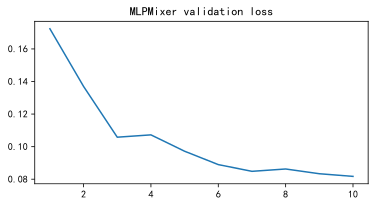

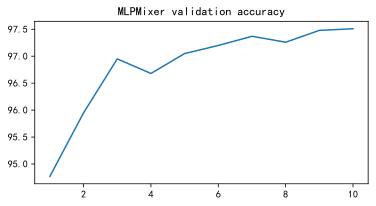

In [74]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,3))
plt.plot(np.arange(1,epochs+1), MLPMixerlossv)
plt.title('MLPMixer validation loss')

plt.figure(figsize=(6,3))
plt.plot(np.arange(1,epochs+1),  MLPMixeraccv)
plt.title('MLPMixer validation accuracy');

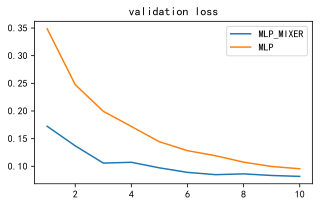

In [76]:
#对比
#让图像清晰
%config InlineBackend.figure_format = 'svg'
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(np.arange(1,epochs+1), MLPMixerlossv)
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
plt.legend(["MLP_MIXER","MLP"])

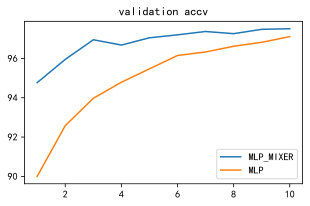

In [77]:
#对比
#让图像清晰
%config InlineBackend.figure_format = 'svg'
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(np.arange(1,epochs+1), MLPMixeraccv)
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accv')
plt.legend(["MLP_MIXER","MLP"])